# Training and Testing Support Vector Machine

### Importing and Loading

In [2]:
# Import resources
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
data = pd.read_csv("training_data_lowercase.csv", sep="\t", header=None, names=["label", "text"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jurge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jurge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Cleaning Dataframe

In [3]:
# Preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
    words = text.split()  # Simple split for tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing
data['text'] = data['text'].apply(preprocess_text)

# Convert labels to integers
data['label'] = data['label'].astype(int)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.3, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Training Model

In [4]:
# Simplified SVM Model
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_tfidf, y_train)

# Predictions
svm_train_pred = svm.predict(X_train_tfidf)
svm_test_pred = svm.predict(X_test_tfidf)

# Evaluation
svm_train_accuracy = accuracy_score(y_train, svm_train_pred)
svm_test_accuracy = accuracy_score(y_test, svm_test_pred)
svm_report = classification_report(y_test, svm_test_pred)

### Model Results

SVM Results:
Training Accuracy: 0.97
Testing Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5295
           1       0.93      0.95      0.94      4951

    accuracy                           0.94     10246
   macro avg       0.94      0.94      0.94     10246
weighted avg       0.94      0.94      0.94     10246



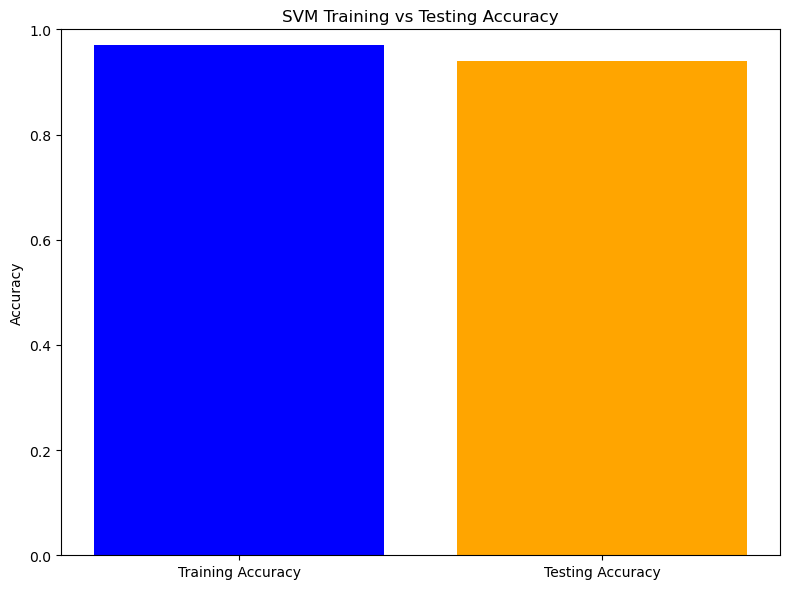

In [5]:
# Output Results
print("SVM Results:")
print(f"Training Accuracy: {svm_train_accuracy:.2f}")
print(f"Testing Accuracy: {svm_test_accuracy:.2f}")
print("Classification Report:")
print(svm_report)

# Graphical Representation
plt.figure(figsize=(8, 6))
bars = ['Training Accuracy', 'Testing Accuracy']
accuracy_values = [svm_train_accuracy, svm_test_accuracy]

plt.bar(bars, accuracy_values, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('SVM Training vs Testing Accuracy')
plt.tight_layout()
plt.show()

# Apply SVM to unlabeled data


### Clean Dataframe

In [6]:
# Load the unlabeled data
unlabeled_data = pd.read_csv("testing_data_lowercase_nolabels.csv", sep="\t", header=None, names=["label", "text"])
data = pd.read_csv("training_data_lowercase.csv", sep="\t", header=None, names=["label", "text"])

# Preprocess the text
unlabeled_data['text'] = unlabeled_data['text'].apply(preprocess_text)

# Transform the unlabeled data
X_unlabeled_tfidf = tfidf_vectorizer.transform(unlabeled_data['text'])

print(unlabeled_data.head)

<bound method NDFrame.head of      label                                               text
0        2   copycat muslim terrorist arrested assault weapon
1        2  wow chicago protester caught camera admits vio...
2        2           germany fdp look fill schaeuble big shoe
3        2  mi school sends welcome back packet warning ki...
4        2  u n seek massive aid boost amid rohingya emerg...
...    ...                                                ...
9979     2  boom fox news leftist chris wallace attempt tr...
9980     2  list democrat hypocrite voted filibuster gw bu...
9981     2  new fire ravage rohingya village northwest mya...
9982     2  meal wheel shuts lyin lefty truth moveon org f...
9983     2  brilliant tucker carlson ayaan hirsi ali discu...

[9984 rows x 2 columns]>


### Run Model

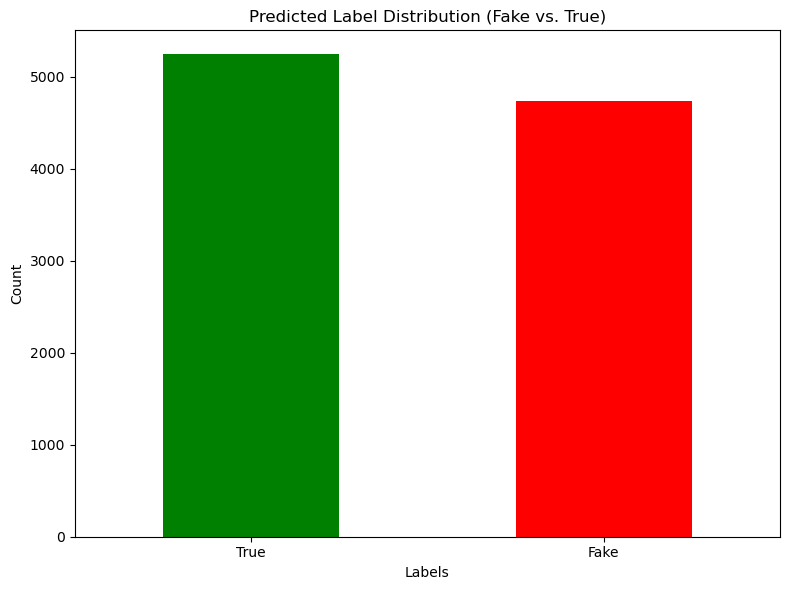

Predicted Label Distribution:
predicted_class
True    5244
Fake    4740
Name: count, dtype: int64


In [9]:
# Predict unlabeled data
predicted_labels = svm.predict(X_unlabeled_tfidf)

# Map numerical predictions to classes
label_mapping = {0: "Fake", 1: "True"}
unlabeled_data['predicted_class'] = pd.Series(predicted_labels).map(label_mapping)

# Overwrite the original labels
unlabeled_data['label'] = predicted_labels

# Add additional column
unlabeled_data.insert(
    unlabeled_data.columns.get_loc('text') + 1, 
    'predicted_class',                 
    unlabeled_data.pop('predicted_class') 
)

# Save the updated dataframe
unlabeled_data_path = 'unlabeled_data.csv'
unlabeled_data.to_csv(unlabeled_data_path, index=False)

# Plot the distribution of categories
label_counts = unlabeled_data['predicted_class'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Predicted Label Distribution (Fake vs. True)')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print distribution counts for inspection
print("Predicted Label Distribution:")
print(label_counts)
